In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['test', 'training', 'SampleSubmission.csv', 'IdLookupTable.csv']


In [2]:
train = pd.read_csv('../input/training/training.csv')
test = pd.read_csv('../input/test/test.csv')
lookid_data = pd.read_csv('../input/IdLookupTable.csv')

In [3]:
train.head().T
# 30 labels(target variables) + 1 column of image pixels data

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


In [4]:
train_image = train['Image']
y = train.iloc[:,:-1]

In [5]:
test_copy = test.copy()
test = test.drop(['ImageId'],axis=1)

In [6]:
#MISSING VALUE checking
number_missing = y.isnull().sum()
percentage_missing = (100*y.isnull().sum()/y.isnull().count())
missing_data = pd.concat([number_missing,percentage_missing],keys=['number_missing','percentage_missing'],axis=1)
missing_data

,number_missing,percentage_missing
left_eye_center_x,10,0.141864
left_eye_center_y,10,0.141864
right_eye_center_x,13,0.184423
right_eye_center_y,13,0.184423
left_eye_inner_corner_x,4778,67.782664
left_eye_inner_corner_y,4778,67.782664
left_eye_outer_corner_x,4782,67.839410
left_eye_outer_corner_y,4782,67.839410
right_eye_inner_corner_x,4781,67.825223
right_eye_inner_corner_y,4781,67.825223


In [7]:
# There is almost 68% data missing of some variables, we can't drop the variables nor can remove the
# rows. Either do missing value imputation by mean or previous value or just run model without it and see
# y1 is target variable with missing value imputed
y1 = y.fillna(y.mean(axis=0))                 #score 4.4
y.fillna(method = 'ffill',inplace=True)       # score 3.3

In [8]:
# coverting object type to numeric
# this is good function to convert multiple object type cols to numeric at once
y = y.convert_objects(convert_numeric=True)     

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# converting image column data to reqd. numeric format and correct shape
ntrain = train.shape[0]
image = []
for i in range (0,ntrain):
    img = train_image[i].split(' ')
    img = [0 if x =='' else x for x in img]
    image.append(img)


In [10]:
image_list = np.array(image,dtype = 'float')
X = image_list.reshape(-1,96,96,1)
type(X)

numpy.ndarray

In [11]:
# scaling pixel values
X = X/255

In [12]:
ntest = test.shape[0]
image = []
for i in range (0,ntest):
    img = test['Image'][i].split(' ')
    img = [0 if x =='' else x for x in img]
    image.append(img)
image_list = np.array(image,dtype = 'float')
test_data = image_list.reshape(-1,96,96,1)
test_data = test_data/255

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

In [14]:
model = Sequential()

'''
NOTE: here we are not using conv2D layer, bcoz we want to detect particular points at multile location
Conv2D could collapse points data when filter is applied, thereby removing important information
Althogh, I tried Conv2D also and its variations, it was giving similar performance. 
But I beileve not using it would be better
'''
model.add(Flatten(input_shape = (96,96,1)))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dense(30))

In [15]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mse', metrics=['mae'],optimizer='adam')


In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
# This is used for callbacks, but it is not giving much improvement in model. This could rather lead
# to overfitting for validation set.

In [17]:
history = model.fit(x_train, y_train, batch_size=150, epochs=150, verbose=1,validation_data = (x_test, y_test))

Train on 5991 samples, validate on 1058 samples
Epoch 1/150
5991/5991 [==============================] - 3s 510us/step - loss: 754.5868 - mean_absolute_error: 20.8684 - val_loss: 158.8746 - val_mean_absolute_error: 9.5258
Epoch 2/150
5991/5991 [==============================] - 1s 89us/step - loss: 186.2315 - mean_absolute_error: 10.4415 - val_loss: 135.1541 - val_mean_absolute_error: 8.7201
Epoch 3/150
5991/5991 [==============================] - 1s 89us/step - loss: 162.3260 - mean_absolute_error: 9.6874 - val_loss: 126.9131 - val_mean_absolute_error: 8.4814
Epoch 4/150
5991/5991 [==============================] - 1s 88us/step - loss: 150.1981 - mean_absolute_error: 9.2577 - val_loss: 119.7633 - val_mean_absolute_error: 8.2763
Epoch 5/150
5991/5991 [==============================] - 1s 89us/step - loss: 136.8993 - mean_absolute_error: 8.8216 - val_loss: 114.2389 - val_mean_absolute_error: 8.0923
Epoch 6/150
5991/5991 [==============================] - 1s 87us/step - loss: 129.1247 - 

5991/5991 [==============================] - 1s 88us/step - loss: 47.4524 - mean_absolute_error: 5.1022 - val_loss: 44.3799 - val_mean_absolute_error: 4.8822
Epoch 49/150
5991/5991 [==============================] - 1s 88us/step - loss: 45.8670 - mean_absolute_error: 5.0092 - val_loss: 49.6735 - val_mean_absolute_error: 5.2135
Epoch 50/150
5991/5991 [==============================] - 1s 88us/step - loss: 40.4062 - mean_absolute_error: 4.6770 - val_loss: 60.9086 - val_mean_absolute_error: 5.9671
Epoch 51/150
5991/5991 [==============================] - 1s 87us/step - loss: 44.1531 - mean_absolute_error: 4.9195 - val_loss: 49.2868 - val_mean_absolute_error: 5.2148
Epoch 52/150
5991/5991 [==============================] - 1s 88us/step - loss: 50.7845 - mean_absolute_error: 5.2903 - val_loss: 54.2896 - val_mean_absolute_error: 5.4529
Epoch 53/150
5991/5991 [==============================] - 1s 89us/step - loss: 40.3741 - mean_absolute_error: 4.6969 - val_loss: 55.1526 - val_mean_absolute_e

Epoch 96/150
5991/5991 [==============================] - 1s 88us/step - loss: 18.1931 - mean_absolute_error: 3.1239 - val_loss: 20.0963 - val_mean_absolute_error: 3.2597
Epoch 97/150
5991/5991 [==============================] - 1s 87us/step - loss: 17.9817 - mean_absolute_error: 3.0875 - val_loss: 26.1572 - val_mean_absolute_error: 3.8487
Epoch 98/150
5991/5991 [==============================] - 1s 87us/step - loss: 18.8991 - mean_absolute_error: 3.1841 - val_loss: 36.8039 - val_mean_absolute_error: 4.7857
Epoch 99/150
5991/5991 [==============================] - 1s 89us/step - loss: 19.2045 - mean_absolute_error: 3.1891 - val_loss: 20.4833 - val_mean_absolute_error: 3.1978
Epoch 100/150
5991/5991 [==============================] - 1s 88us/step - loss: 22.2004 - mean_absolute_error: 3.4551 - val_loss: 20.8562 - val_mean_absolute_error: 3.3717
Epoch 101/150
5991/5991 [==============================] - 1s 89us/step - loss: 17.4391 - mean_absolute_error: 3.0332 - val_loss: 17.6683 - val_

Epoch 144/150
5991/5991 [==============================] - 1s 88us/step - loss: 11.8884 - mean_absolute_error: 2.4587 - val_loss: 15.1298 - val_mean_absolute_error: 2.8642
Epoch 145/150
5991/5991 [==============================] - 1s 86us/step - loss: 12.8029 - mean_absolute_error: 2.5785 - val_loss: 16.1991 - val_mean_absolute_error: 2.9767
Epoch 146/150
5991/5991 [==============================] - 1s 89us/step - loss: 10.2614 - mean_absolute_error: 2.2328 - val_loss: 15.0578 - val_mean_absolute_error: 2.8350
Epoch 147/150
5991/5991 [==============================] - 1s 89us/step - loss: 9.6910 - mean_absolute_error: 2.1505 - val_loss: 11.7208 - val_mean_absolute_error: 2.3151
Epoch 148/150
5991/5991 [==============================] - 1s 89us/step - loss: 11.0060 - mean_absolute_error: 2.3440 - val_loss: 20.1614 - val_mean_absolute_error: 3.4592
Epoch 149/150
5991/5991 [==============================] - 1s 89us/step - loss: 10.1638 - mean_absolute_error: 2.2237 - val_loss: 17.5694 - v

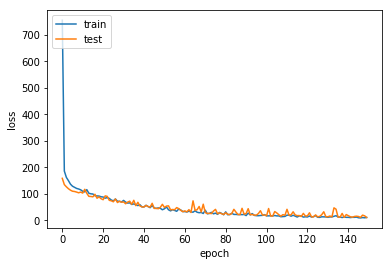

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
#predicting test_data
y_pred = model.predict(test_data)

In [20]:
df = pd.DataFrame(y_pred)
df.columns = train.columns[0:30]
df = df.T
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782
left_eye_center_x,60.396484,64.708504,64.547638,65.699417,64.016403,66.701233,66.847488,65.379692,66.375542,65.334778,65.842499,65.451889,62.434330,62.040314,66.101166,62.166531,67.076103,63.554943,64.173409,63.350491,63.444950,64.294693,61.427002,63.121181,67.289658,64.413063,67.101433,63.726013,65.757401,66.574921,61.080276,63.901680,64.496284,62.603344,64.308884,65.753471,65.838753,65.600052,64.413277,65.645927,...,66.830315,62.022884,67.462593,62.717491,67.132851,65.836296,68.692566,71.071053,65.594177,65.373230,65.078827,61.217171,66.828682,67.714943,71.875046,61.136608,65.746536,67.298447,63.035835,67.165092,64.957443,63.987381,66.697250,62.251663,69.794533,65.842285,65.796402,63.937931,68.017097,66.223633,65.588051,67.010529,61.336163,63.177460,66.396500,64.815643,64.750031,66.451202,64.416260,62.440159
left_eye_center_y,33.448219,35.374767,34.842319,36.620640,35.328293,37.327911,36.232212,35.444248,38.039017,35.890030,37.744801,37.428471,34.786949,34.994247,38.104694,35.864967,37.448841,36.011478,34.751087,34.695572,34.944206,36.662399,35.087688,37.809315,36.702705,34.682751,37.184631,35.269608,37.164509,37.234173,34.359333,35.040016,35.810455,35.897938,37.132744,37.793758,35.996098,36.773945,35.353355,36.298279,...,36.347244,35.768097,39.161510,33.395542,40.412338,38.287178,40.083473,38.152721,38.114445,36.220634,36.872757,36.010345,39.180527,38.301022,38.880981,34.051628,37.995399,38.946487,36.332886,37.105576,37.112598,36.616787,37.202435,36.634197,42.219486,37.746895,37.261040,36.525452,40.678566,38.362637,37.139774,34.064159,34.626842,37.161430,37.724007,38.447960,33.666851,38.772335,37.090508,36.027908
right_eye_center_x,27.032059,28.467258,28.438595,29.043827,28.950821,30.021601,28.888485,28.408924,29.776125,29.388533,28.798607,28.917078,27.603834,27.528645,29.527386,28.170044,28.662781,30.515570,27.550465,28.849552,28.509624,28.829424,27.719460,29.288912,29.873362,28.460484,29.507851,27.991268,28.534006,31.262403,27.242533,28.996490,29.201134,28.641737,29.561567,30.090393,28.905869,28.644243,28.053534,29.129272,...,30.175854,28.584087,31.010336,28.066669,29.499411,30.608835,31.321339,30.932590,30.980133,29.953453,29.641806,28.581917,30.645288,30.252518,31.898090,27.641735,29.025425,30.876295,29.499014,29.635565,29.697559,29.046511,29.885748,28.000282,33.883095,29.988272,29.675562,28.942863,30.473768,30.531416,28.873472,29.924942,28.590973,28.557535,29.371288,30.314802,28.961782,29.772736,29.301752,28.774132
right_eye_center_y,34.476723,36.148472,35.556274,37.269196,36.087528,36.957787,37.746166,35.839787,36.294140,35.887352,35.411430,37.022221,34.984211,35.289448,36.846821,34.839657,36.906231,37.555641,35.910622,35.449974,36.333691,36.266750,34.524220,35.797371,38.425919,37.473263,37.220905,35.931648,36.915188,38.943157,34.378113,35.977974,36.161888,35.748295,35.845139,36.902260,36.029690,35.837387,36.632439,36.939342,...,37.907211,35.866268,38.975452,37.519829,35.674858,38.653656,38.235546,41.783348,38.910183,38.189320,36.353233,35.607075,37.202908,40.008152,43.050144,35.592793,37.163376,38.999847,36.480415,38.755478,37.312157,37.474758,38.132980,35.395248,41.314240,37.320221,37.994404,36.924698,37.551456,38.523174,37.479252,40.675774,36.747818,35.078217,38.482986,36.526585,39.585472,37.225075,37.203354,35.858448
left_eye_inner_corner_x,54.064026,57.650921,58.701492,58.364777,58.070435,59.098736,58.981403,58.589760,59.908699,58.162502,59.227062,58.600368,55.774590,55.332607,59.702797,56.467152,59.191376,57.627029,58.022526,56.564304,57.409222,58.125397,55.943420,56.749763,61.324272,57.401249,60.253040,57.134487,58.445278,60.216408,54.605022,58.401970,58.342487,57.012070,57.889942,59.449780,60.011375,5

In [ ]:
sub = lookid_data

for i in range(sub.shape[0]):
    row = sub.loc[i,'FeatureName']
    col = sub.loc[i,'ImageId'] - 1
    sub.loc[i,'Location'] = df.loc[row, col]
sub = sub.drop(['ImageId', 'FeatureName'],axis=1)
sub.head()

In [ ]:
sub.to_csv('facial_2.csv',index=False)